This article was inspired by a post I saw in LinkedIn and further motivated by the comments I saw on the post. Here's the post link for reference: https://bit.ly/2YlSdS3 

The problem we are trying to solve is to clean the text data and group similar names together into one category based on our knowledge of one of the forms in which these names appear

I have downloaded this dataset from <a href="https://www.kaggle.com/c/fuzzy-security/data?select=train.csv">kaggle</a> and it includes names of comapanies in the SEC database. The names of the companies are not consistent but the key for each company is unique. I am going to try to find all the matches of a company name using Levenshtein distance matching and cosine similarity then will compare the performance against the the unique keys provided. I will start by importing some python libraries and reading in the CSV as a Pandas dataframe. (This is still a work in progress as I intend to use unsupervised machine learning to group similar strings together)

<h3> 1. Importing Libraries and Loading Data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import string
import random
import Levenshtein as lev
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import linear_model
from sklearn.metrics import classification_report, confusion_matrix
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib
data = pd.read_csv('sec__edgar_company_info.csv')

Now that the data in loaded into a dataframe we'll do some quick relevant analysis to get to know what the data looks like. I will look at the first 20 rows of the dataframe just to get some intuition as to what it is that I am dealing with

In [2]:
data.head(20)

,Line Number,Company Name,Company CIK Key
0,1,!J INC,1438823
1,2,"#1 A LIFESAFER HOLDINGS, INC.",1509607
2,3,#1 ARIZONA DISCOUNT PROPERTIES LLC,1457512
3,4,#1 PAINTBALL CORP,1433777
4,5,$ LLC,1427189
5,6,& S MEDIA GROUP LLC,1447162
6,7,&TV COMMUNICATIONS INC.,1479357
7,8,"'MKTG, INC.'",886475
8,9,'OHANA LABS INC.,1703629
9,10,(OURCROWD INVESTMENT IN MST) L.P.,1599496


<h3> 2. Data Preparation and String Porocessing

As we can see we have a table with three columns. The most two relevant columns for our use case are the Compnay Name and the Company CIK Key columns (I honestly think the line number column is useless but there is no description of the dataset on Kaggle so I am not very sure). I will ignore the companies CIK's for now and proceed as if only had a series of strings just like in a realistic situation where you may want to find the strings that are similar relative to some target string. It looks like the text in the Company Name column has a little too much punctuation that is not necessary.I also need to get the data into a data structure that I can effictively work with to process the text. Hence, I will store the elements of the Company name column in a numpy array and do some text processing. 

In [3]:
companyNames= data[['Company Name']].to_numpy().flatten()

#for loop to iterate over each string to process it
#Could use python's map function to speed up the loop?
for i in range (0, len(companyNames)):
     companyNames[i] = str(companyNames[i]).translate(str.maketrans('', '', string.punctuation)).lower()
#print first 5 elements of the processed text        
print(companyNames[0:5])

['j inc' '1 a lifesafer holdings inc' '1 arizona discount properties llc'
 '1 paintball corp' ' llc']


The previous for loop iterates over each element of the companyNames array, removes punctuation and then replaces the string with the lowercase string. Now we need to pick a target element from the companyNames array and try to find similar elements in the array. I will pick the target at random but I will seed the value to obtain reproducible results.

In [4]:
random.seed(100)
target_index = random.randint(0,len(companyNames))
target = companyNames[target_index]
print ('target string: ' + target)

target string: darwin michael a


<h3> 3.a Using Levenshtein distance

I will first initialize a vector of the same lenght of the company names array. 
Then I will fill each element of the vector based on how simialr the target and the element are percenatge wise. Read more about Levenshtein percentage here: https://www.aclweb.org/anthology/S16-1108.pdf

In [5]:
LevenshteinVector = np.zeros(len(companyNames))
for i in range (0, len(LevenshteinVector)):
    LevenshteinVector[i] = lev.ratio(target,companyNames[i])

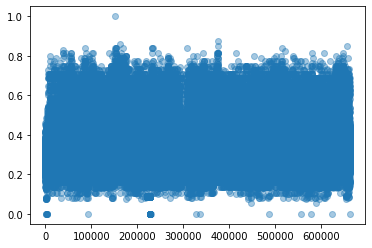

In [6]:
#This is a simple plot that shows the score of each element percentage wise.
plt.plot(LevenshteinVector, 'o', alpha = 0.4)

Now a simple way to get matches is to get the elements that score above some constant threshold value (typically 0.8) but this approach tends not perform well with different target values especially considering that the number of the entries in this dataset is beyond 600K. A better approach is to use some percentile value as a threshold as it is a less static way of of doing things and will adapt will to different targets. I will use 99.999 as my percentile value here and again when I use the cosine similarity method.

In [7]:
LevenshteinPercentile = np.percentile(LevenshteinVector, 99.999)
#Get boolean values for whether an element is greater than the the 
#percentile value then use the returened values as a mask
#to get the element in the Company names array
#that pass the boolean test
Levenshteinmask = (LevenshteinVector > LevenshteinPercentile)
#print matches 
print(companyNames[Levenshteinmask])

['brown michael a' 'darling michael' 'darwin michael a' 'davin michael r'
 'davis michael a' 'davis michael a' 'desjardin michael a'
 'doris michael a' 'garin michael j' 'garin michael n' 'gawin michael j'
 'irwin michael j' 'martin michael a' 'martino michael a'
 'rubin michael a' 'yeargin michael a']


<b>As you can the target 'darwin michael a' is in the list we obtain by using the mask and the other values we obtain are very similar.

<h3> 3.b Using Cosine similarity

We'll make use of the very powerful library Scikit to help us with the cosine similarity task. We'll utilize it's ability to implement tf-idf algorithm to create a matrix of the corpse for us. The tfidf vectorizer compares words as matrices representation. So I will define a vector that is a flattened version of the output of the comparison of the matrix represtation of my target value and that of the matrix represnation of every other element in the company names array.

In [8]:
#Initialize a vectorizer
tfidf_vectorizer = TfidfVectorizer()
#build tfidf matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(companyNames)
#Compare target to other elements using cosine similarity
CosineSimilarityVector = cosine_similarity(tfidf_matrix[target_index-1:target_index], tfidf_matrix).flatten()

Here I create a plot similar to the one I created before to help me visualize what is going on under the hood.

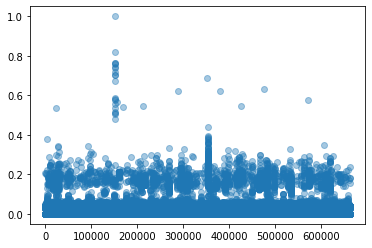

In [9]:
plt.plot(CosineSimilarityVector,'o', alpha = 0.4)

Using the same logic from before I will rely on a percentile value instead of some fixed threshold 

In [10]:
CosinePercentile = np.percentile(CosineSimilarityVector, 99.999)
mask = (CosineSimilarityVector>CosinePercentile)
print(companyNames[mask])

['darwin capital lp' 'darwin capital partners l p' 'darwin holdings ltd'
 'darwin life inc' 'darwin michael a' 'darwin partners inc'
 'darwin resources inc']


<b> As we can see again the value 'darwin michael a' is in the list we obtain from using the mask along with some very similar looking strings

<h3> 3.c Using the key values to find out how many matches there actually are

In [11]:
#Get the keys as a numpy array
keys= data[['Company CIK Key']].to_numpy().flatten()
#Using a mask again that matches the actual key 
#of the target to all other keys of equal value
truthMask = (keys == keys[target_index])
print(companyNames[truthMask])
print(keys[truthMask])

['darwin michael a']
[1211035]


<h3> 3.b Final remarks and taking it further

As shown above there was only one match and both methods were able to find it along with other very similar looking strings. To me the results of each method were indistinguishable from each other. Which begs the question as to whether some form of unsupervised machine learning can help me group all these similar strings together. But then I would need features. Luckily for me have already figured out how to create vectors that can be turned into features. My intuition is that if I have some similarity vectors and plot them against each other, the words would group according to how similar or different they are to the vectors. I would need to confirm this at least visualy to make sure that there is some clustering in the data. I will create two vectors (aka features) using Levenshtein and two other vectors using cosine similiraity. Then will plot the vectors obtained by each method against each other and hope for the best. 

<h3> 4. To cluster or not to cluster


<h3>  4.a Using Levenshtein Similarity Vectors

First I will need to define a function that will generate a Levenshtein similarity vector from a random target

Text(0, 0.5, 'V2')

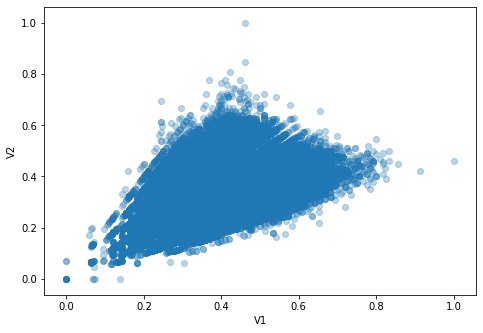

In [12]:
def LevenshteinVector (StringArray):
    """
    Create a vector by comparing an element chosen at random from StringArray
    to every other element using Levenshtein ratio

    Parameters
    ----------

    :param StringArray: iterable conataing strings

    Iterable of strings from which a similarity vector will be created

    :param kwargs:
    :return: 1-D numpy array (similarity vector)
    """
    #This method reuses the code from 3.a
    target_index = random.randint(0,len(StringArray))
    target = StringArray[target_index]
    vector = np.zeros(len(StringArray))
    for i in range (0, len(vector)):
        vector[i] = lev.ratio(target,StringArray[i])
    return vector

vector1 = LevenshteinVector(companyNames)
vector2 = LevenshteinVector(companyNames)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(vector1, vector2, alpha = 0.3)
ax.set_xlabel('V1')
ax.set_ylabel('V2')

Running the previous cell multiple times and hence generating mulitple randomly constructed vectors, I notice that there is an obvious split in the data along the radial axis. This is a good enough sign for me to carry on with this idea of clustering with Levenshtein distancing.

<h3> 4.a Using Cosine Similarity Vectors

I will create a function that outputs a cosine similarity vector using some random target word and then plot two vectors against each other.

Text(0, 0.5, 'V2')

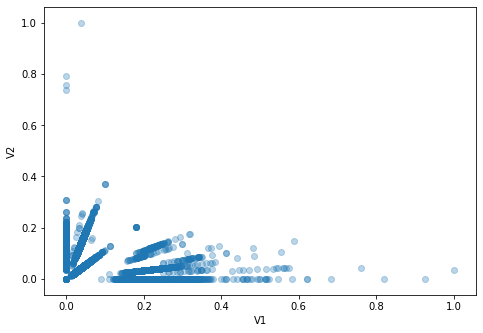

In [13]:
#should make this function less dependant on global variables.
#Will fix when I come back to try to cluster the data
def cosineVec(StringArray):
    num = random.randint(0,len(StringArray))
    vector = cosine_similarity(tfidf_matrix[num-1:num], tfidf_matrix).flatten()
    return vector
vector1 = cosineVec(companyNames)
vector2 = cosineVec(companyNames)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(vector1, vector2, alpha = 0.3)
ax.set_xlabel('V1')
ax.set_ylabel('V2')

Running the previous cell multiple lines I notice that the data splits into two major areas. Along V1 dimension and the V2 dimension. This is also a good sign that a clustering algorithm can be used. 